In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:33:57 2023

@author: Lin
"""

import os
os.chdir("../")
current_path = os.getcwd()
print(current_path)
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
sys.path.append(current_path+'/../calculate_tangent/')
import myInput
import PACKAGE_MP_Linear as linear2d











/home/lin.yang/projects/VECTOR/examples/plot_GG_property


In [13]:

def simple_magnitude(freqArray):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray_circle = np.ones(binNum)
    freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)

    magnitude_max = np.max(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)
    magnitude_ave = np.average(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)

    magnitude_stan = np.sqrt(np.sum((abs(freqArray - freqArray_circle)/np.average(freqArray_circle) - magnitude_ave)**2)/binNum)

    return magnitude_ave, magnitude_stan

    # coeff_high = abs(np.cos((xCor-90)/180*np.pi))
    # coeff_low = abs(np.cos((xCor)/180*np.pi))
    # return np.sum(freqArray * coeff_high)/np.sum(freqArray * coeff_low)

def find_fittingEllipse2(array): #failure
    K_mat = []
    Y_mat = []

    # Get the self-variable
    X = array[:,0]
    Y = array[:,1]

    K_mat = np.hstack([X**2, X*Y, Y**2, X, Y])
    Y_mat = np.ones_like(X)

    X_mat = np.linalg.lstsq(K_mat, Y_mat)[0].squeeze()
    # X_mat = (K_mat.T*K_mat).I * K_mat.T * Y_mat

    print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(X_mat[0], X_mat[1], X_mat[2], X_mat[3], X_mat[4]))
    print(X_mat)

    return X_mat

def get_poly_center(micro_matrix, step):
    # Get the center of all non-periodic grains in matrix
    num_grains = int(np.max(micro_matrix[step,:]))
    center_list = np.zeros((num_grains,2))
    sites_num_list = np.zeros(num_grains)
    ave_radius_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    table = micro_matrix[step,:,:,0]
    for i in range(num_grains):
        sites_num_list[i] = np.sum(table == i+1)

        if (sites_num_list[i] < 500) or \
           (np.max(coord_refer_i[table == i+1]) - np.min(coord_refer_i[table == i+1]) == micro_matrix.shape[1]) or \
           (np.max(coord_refer_j[table == i+1]) - np.min(coord_refer_j[table == i+1]) == micro_matrix.shape[2]): # grains on bc are ignored
          center_list[i, 0] = 0
          center_list[i, 1] = 0
          sites_num_list[i] == 0
        else:
          center_list[i, 0] = np.sum(coord_refer_i[table == i+1]) / sites_num_list[i]
          center_list[i, 1] = np.sum(coord_refer_j[table == i+1]) / sites_num_list[i]
    ave_radius_list = np.sqrt(sites_num_list / np.pi)

    return center_list, ave_radius_list

def get_poly_statistical_radius(micro_matrix, sites_list, step):
    # Get the max offset of average radius and real radius
    center_list, ave_radius_list = get_poly_center(micro_matrix, step)
    num_grains = int(np.max(micro_matrix[step,:]))

    max_radius_offset_list = np.zeros(num_grains)
    for n in range(num_grains):
        center = center_list[n]
        ave_radius = ave_radius_list[n]
        sites = sites_list[n]

        if ave_radius != 0:
          for sitei in sites:
              [i,j] = sitei
              current_radius = np.sqrt((i - center[0])**2 + (j - center[1])**2)
              radius_offset = abs(current_radius - ave_radius)
              if radius_offset > max_radius_offset_list[n]: max_radius_offset_list[n] = radius_offset

          max_radius_offset_list[n] = max_radius_offset_list[n] / ave_radius

    max_radius_offset = np.average(max_radius_offset_list[max_radius_offset_list!=0])
    area_list = np.pi*ave_radius_list*ave_radius_list
    if np.sum(area_list) == 0: max_radius_offset = 0
    else: max_radius_offset = np.sum(max_radius_offset_list * area_list) / np.sum(area_list)

    return max_radius_offset

def get_poly_statistical_ar(micro_matrix, step):
    # Get the average aspect ratio
    num_grains = int(np.max(micro_matrix[step,:]))
    sites_num_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    aspect_ratio_i = np.zeros((num_grains,2))
    aspect_ratio_j = np.zeros((num_grains,2))
    aspect_ratio = np.zeros(num_grains)
    table = micro_matrix[step,:,:,0]

    aspect_ratio_i_list = [[] for _ in range(int(num_grains))]
    aspect_ratio_j_list = [[] for _ in range(int(num_grains))]
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            grain_id = int(table[i][j]-1)
            sites_num_list[grain_id] +=1
            aspect_ratio_i_list[grain_id].append(coord_refer_i[i][j])
            aspect_ratio_j_list[grain_id].append(coord_refer_j[i][j])

    for i in range(num_grains):
        aspect_ratio_i[i, 0] = len(list(set(aspect_ratio_i_list[i])))
        aspect_ratio_j[i, 1] = len(list(set(aspect_ratio_j_list[i])))
        if aspect_ratio_j[i, 1] == 0: aspect_ratio[i] = 0
        else: aspect_ratio[i] = aspect_ratio_i[i, 0] / aspect_ratio_j[i, 1]

    # aspect_ratio = np.average(aspect_ratio[aspect_ratio!=0])
    aspect_ratio = np.sum(aspect_ratio * sites_num_list) / np.sum(sites_num_list)

    return aspect_ratio

def get_normal_vector(grain_structure_figure_one, grain_num):
    nx = grain_structure_figure_one.shape[0]
    ny = grain_structure_figure_one.shape[1]
    ng = np.max(grain_structure_figure_one)
    cores = 32
    loop_times = 5
    P0 = grain_structure_figure_one
    R = np.zeros((nx,ny,2))
    smooth_class = linear2d.linear_class(nx,ny,ng,cores,loop_times,P0,R)

    smooth_class.linear_main("inclination")
    P = smooth_class.get_P()
    # sites = smooth_class.get_gb_list(1)
    # print(len(sites))
    # for id in range(2,grain_num+1): sites += smooth_class.get_gb_list(id)
    # print(len(sites))
    sites = smooth_class.get_all_gb_list()
    sites_together = []
    for id in range(len(sites)): sites_together += sites[id]
    print("Total num of GB sites: " + str(len(sites_together)))

    return P, sites_together, sites

def get_normal_vector_slope(P, sites, step, para_name, bias=None):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray = np.zeros(binNum)
    degree = []
    for sitei in sites:
        [i,j] = sitei
        dx,dy = myInput.get_grad(P,i,j)
        degree.append(math.atan2(-dy, dx) + math.pi)
        # if dx == 0:
        #     degree.append(math.pi/2)
        # elif dy >= 0:
        #     degree.append(abs(math.atan(-dy/dx)))
        # elif dy < 0:
        #     degree.append(abs(math.atan(dy/dx)))
    for i in range(len(degree)):
        freqArray[int((degree[i]/math.pi*180-xLim[0])/binValue)] += 1
    freqArray = freqArray/sum(freqArray*binValue)

    if bias is not None:
        freqArray = freqArray + bias
        freqArray = freqArray/sum(freqArray*binValue)
    # Plot
    # plt.close()
    # fig = plt.figure(figsize=(5, 5))
    # ax = plt.gca(projection='polar')

    # ax.set_thetagrids(np.arange(0.0, 360.0, 20.0),fontsize=14)
    # ax.set_thetamin(0.0)
    # ax.set_thetamax(360.0)

    # ax.set_rgrids(np.arange(0, 0.008, 0.004))
    # ax.set_rlabel_position(0.0)  # 标签显示在0°
    # ax.set_rlim(0.0, 0.008)  # 标签范围为[0, 5000)
    # ax.set_yticklabels(['0', '0.004'],fontsize=14)

    # ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    # ax.set_axisbelow('True')
    plt.plot(np.append(xCor,xCor[0])/180*math.pi, np.append(freqArray,freqArray[0]), linewidth=2, label=para_name)

    # fitting
    fit_coeff = np.polyfit(xCor, freqArray, 1)
    return freqArray

if __name__ == '__main__':
    # File name
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/results/"
    TJ_energy_type_ave = "ave"
    TJ_energy_type_consMin = "consMin"
    TJ_energy_type_sum = "sum"
    TJ_energy_type_min = "min"
    TJ_energy_type_max = "max"
    TJ_energy_type_consMax = "consMax"


    npy_file_name_iso = "p_ori_ave_aveE_20000_multiCore32_delta0.0_m2_J1_refer_1_0_0_seed56689_kt066.npy"
    npy_file_name_aniso_ave = f"p_randomtheta0_{TJ_energy_type_ave}E_20000_delta0.6_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_consMin = f"pm_randomtheta0_{TJ_energy_type_consMin}E_20000_delta0.6_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_sum = f"pm_randomtheta0_{TJ_energy_type_sum}E_20000_delta0.6_J1_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_min = f"p_randomtheta0_{TJ_energy_type_min}E_20000_delta0.6_J1_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_max = f"p_randomtheta0_{TJ_energy_type_max}E_20000_delta0.6_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_consMax = f"pm_randomtheta0_{TJ_energy_type_consMax}E_20000_delta0.6_J1_refer_1_0_0_seed56689_kt0.66.npy"

    # Initial data
    npy_file_iso = np.load(npy_file_folder + npy_file_name_iso)
    npy_file_aniso_ave = np.load(npy_file_folder + npy_file_name_aniso_ave)
    # npy_file_aniso_consMin = np.load(npy_file_folder + npy_file_name_aniso_consMin)
    # npy_file_aniso_sum = np.load(npy_file_folder + npy_file_name_aniso_sum)
    npy_file_aniso_min = np.load(npy_file_folder + npy_file_name_aniso_min)
    npy_file_aniso_max = np.load(npy_file_folder + npy_file_name_aniso_max)
    # npy_file_aniso_consMax = np.load(npy_file_folder + npy_file_name_aniso_consMax)
    print(f"The ave data size is: {npy_file_aniso_ave.shape}")
    # print(f"The consMin data size is: {npy_file_aniso_consMin.shape}")
    # print(f"The sum data size is: {npy_file_aniso_sum.shape}")
    print(f"The min data size is: {npy_file_aniso_min.shape}")
    print(f"The max data size is: {npy_file_aniso_max.shape}")
    # print(f"The consMax data size is: {npy_file_aniso_consMax.shape}")
    print(f"The iso data size is: {npy_file_iso.shape}")
    print("READING DATA DONE")

    # Initial container
    initial_grain_num = 20000
    step_num = npy_file_aniso_ave.shape[0]

    bin_width = 0.16 # Grain size distribution
    x_limit = [-0.5, 3.5]
    bin_num = round((abs(x_limit[0])+abs(x_limit[1]))/bin_width)
    size_coordination = np.linspace((x_limit[0]+bin_width/2),(x_limit[1]-bin_width/2),bin_num)
    grain_size_distribution_iso = np.zeros(bin_num)
    special_step_distribution_iso = 10#to get 2000 grains
    grain_size_distribution_ave = np.zeros(bin_num)
    special_step_distribution_ave = 12 #to get 2000 grains
    # grain_size_distribution_consMin = np.zeros(bin_num)
    # special_step_distribution_consMin = 12#to get 2000 grains
    # grain_size_distribution_sum = np.zeros(bin_num)
    # special_step_distribution_sum = 12#to get 2000 grains
    grain_size_distribution_iso = np.zeros(bin_num)
    grain_size_distribution_min = np.zeros(bin_num)
    special_step_distribution_min = 22#to get 2000 grains
    grain_size_distribution_max = np.zeros(bin_num)
    special_step_distribution_max = 12#to get 2000 grains
    # grain_size_distribution_consMax = np.zeros(bin_num)
    # special_step_distribution_consMax = 13#to get 2000 grains


    # Get bias from kT test
    special_step_distribution_T066_bias = 10
    data_file_name_bias = f'/normal_distribution_data/normal_distribution_T066_bias_sites_step{special_step_distribution_T066_bias}.npy'
    if os.path.exists(current_path + data_file_name_bias):
        slope_list_bias = np.load(current_path + data_file_name_bias)
    else:
        data_file_name_P = f'/normal_distribution_data/normal_distribution_iso_P_step{special_step_distribution_T066_bias}.npy'
        data_file_name_sites = f'/normal_distribution_data/normal_distribution_iso_sites_step{special_step_distribution_T066_bias}.npy'
        if os.path.exists(current_path + data_file_name_P):
            P = np.load(current_path + data_file_name_P)
            sites = np.load(current_path + data_file_name_sites)
        else:
            newplace = np.rot90(npy_file_iso[special_step_distribution_T066_bias,:,:,:], 1, (0,1))
            P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
            np.save(current_path + data_file_name_P, P)
            np.save(current_path + data_file_name_sites, sites)

        plt.close()
        fig = plt.figure(figsize=(5, 5))
        ax = plt.gca(projection='polar')
        slope_list = get_normal_vector_slope(P, sites, special_step_distribution_T066_bias, "Iso")
        # For bias
        xLim = [0, 360]
        binValue = 10.01
        binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
        freqArray_circle = np.ones(binNum)
        freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)
        slope_list_bias = freqArray_circle - slope_list
        np.save(current_path + data_file_name_bias, slope_list_bias)


The ave data size is: (601, 2400, 2400, 1)
The min data size is: (601, 2400, 2400, 1)
The max data size is: (601, 2400, 2400, 1)
The iso data size is: (601, 2400, 2400, 1)
READING DATA DONE


/scratch/local/21179043/ipykernel_3796283/1496629805.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='polar')


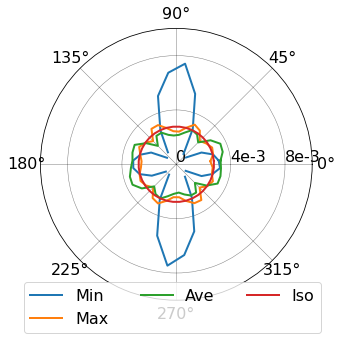

In [25]:
    
    # Start polar figure
    plt.close()
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca(projection='polar')

    ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=16)
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)

    ax.set_rgrids(np.arange(0, 0.01, 0.004))
    ax.set_rlabel_position(0.0)  # 标签显示在0°
    ax.set_rlim(0.0, 0.01)  # 标签范围为[0, 5000)
    ax.set_yticklabels(['0', '4e-3', '8e-3'],fontsize=16)

    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow('True')

    

    aniso_mag = np.zeros(6)
    aniso_mag_stand = np.zeros(6)

    # Aniso - min
    data_file_name_P = f'/normal_distribution_data/normal_distribution_rdt0_min_P_step{special_step_distribution_min}.npy'
    data_file_name_sites = f'/normal_distribution_data/normal_distribution_rdt0_min_sites_step{special_step_distribution_min}.npy'
    if os.path.exists(current_path + data_file_name_P):
        P = np.load(current_path + data_file_name_P)
        sites = np.load(current_path + data_file_name_sites)
    else:
        newplace = np.rot90(npy_file_aniso_min[special_step_distribution_min,:,:,:], 1, (0,1))
        P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
        np.save(current_path + data_file_name_P, P)
        np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_min, "Min",slope_list_bias)
    aniso_mag[0], aniso_mag_stand[0] = simple_magnitude(slope_list)

    # Aniso - max
    data_file_name_P = f'/normal_distribution_data/normal_distribution_rdt0_max_P_step{special_step_distribution_max}.npy'
    data_file_name_sites = f'/normal_distribution_data/normal_distribution_rdt0_max_sites_step{special_step_distribution_max}.npy'
    if os.path.exists(current_path + data_file_name_P):
        P = np.load(current_path + data_file_name_P)
        sites = np.load(current_path + data_file_name_sites)
    else:
        newplace = np.rot90(npy_file_aniso_max[special_step_distribution_max,:,:,:], 1, (0,1))
        P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
        np.save(current_path + data_file_name_P, P)
        np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_max, "Max",slope_list_bias)
    aniso_mag[1], aniso_mag_stand[1] = simple_magnitude(slope_list)

    # Aniso - ave
    data_file_name_P = f'/normal_distribution_data/normal_distribution_rdt0_ave_P_step{special_step_distribution_ave}.npy'
    data_file_name_sites = f'/normal_distribution_data/normal_distribution_rdt0_ave_sites_step{special_step_distribution_ave}.npy'
    if os.path.exists(current_path + data_file_name_P):
        P = np.load(current_path + data_file_name_P)
        sites = np.load(current_path + data_file_name_sites)
    else:
        newplace = np.rot90(npy_file_aniso_ave[special_step_distribution_ave,:,:,:], 1, (0,1))
        P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
        np.save(current_path + data_file_name_P, P)
        np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_ave, "Ave",slope_list_bias)
    aniso_mag[2], aniso_mag_stand[2] = simple_magnitude(slope_list)

#     # Aniso - sum
#     data_file_name_P = f'/normal_distribution_data/normal_distribution_rdt0m_sum_P_step{special_step_distribution_sum}.npy'
#     data_file_name_sites = f'/normal_distribution_data/normal_distribution_rdt0m_sum_sites_step{special_step_distribution_sum}.npy'
#     if os.path.exists(current_path + data_file_name_P):
#         P = np.load(current_path + data_file_name_P)
#         sites = np.load(current_path + data_file_name_sites)
#     else:
#         newplace = np.rot90(npy_file_aniso_sum[special_step_distribution_sum,:,:,:], 1, (0,1))
#         P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
#         np.save(current_path + data_file_name_P, P)
#         np.save(current_path + data_file_name_sites, sites)

#     slope_list = get_normal_vector_slope(P, sites, special_step_distribution_sum, "Sum",slope_list_bias)
#     aniso_mag[3], aniso_mag_stand[3] = simple_magnitude(slope_list)

#     # Aniso - consMin
#     data_file_name_P = f'/normal_distribution_data/normal_distribution_rdt0m_consMin_P_step{special_step_distribution_consMin}.npy'
#     data_file_name_sites = f'/normal_distribution_data/normal_distribution_rdt0m_consMin_P_sites_step{special_step_distribution_consMin}.npy'
#     if os.path.exists(current_path + data_file_name_P):
#         P = np.load(current_path + data_file_name_P)
#         sites = np.load(current_path + data_file_name_sites)
#     else:
#         newplace = np.rot90(npy_file_aniso_consMin[special_step_distribution_consMin,:,:,:], 1, (0,1))
#         P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
#         np.save(current_path + data_file_name_P, P)
#         np.save(current_path + data_file_name_sites, sites)

#     slope_list = get_normal_vector_slope(P, sites, special_step_distribution_consMin, "CMin",slope_list_bias)
#     aniso_mag[4], aniso_mag_stand[4] = simple_magnitude(slope_list)

#     # Aniso - consMax
#     data_file_name_P = f'/normal_distribution_data/normal_distribution_rdt0m_consMax_P_step{special_step_distribution_consMax}.npy'
#     data_file_name_sites = f'/normal_distribution_data/normal_distribution_rdt0m_consMax_sites_step{special_step_distribution_consMax}.npy'
#     if os.path.exists(current_path + data_file_name_P):
#         P = np.load(current_path + data_file_name_P)
#         sites = np.load(current_path + data_file_name_sites)
#     else:
#         newplace = np.rot90(npy_file_aniso_consMax[special_step_distribution_consMax,:,:,:], 1, (0,1))
#         P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
#         np.save(current_path + data_file_name_P, P)
#         np.save(current_path + data_file_name_sites, sites)

#     slope_list = get_normal_vector_slope(P, sites, special_step_distribution_consMax, "CMax",slope_list_bias)
#     aniso_mag[5], aniso_mag_stand[5] = simple_magnitude(slope_list)

    # Aniso - iso
    data_file_name_P = f'/normal_distribution_data/normal_distribution_iso_P_step{special_step_distribution_iso}.npy'
    data_file_name_sites = f'/normal_distribution_data/normal_distribution_iso_sites_step{special_step_distribution_iso}.npy'
    if os.path.exists(current_path + data_file_name_P):
        P = np.load(current_path + data_file_name_P)
        sites = np.load(current_path + data_file_name_sites)
    else:
        newplace = np.rot90(npy_file_iso[special_step_distribution_iso,:,:,:], 1, (0,1))
        P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
        np.save(current_path + data_file_name_P, P)
        np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_iso, "Iso",slope_list_bias)

    plt.legend(loc=(-0.06,-0.12),fontsize=16,ncol=3)
    plt.savefig(current_path + "/figures/normal_distribution_poly_randomtheta0_20k_after_removing_bias.png", dpi=400,bbox_inches='tight')

    # plt.close()
    # fig = plt.figure(figsize=(5, 5))
    # label_list = ["Min", "Max", "Ave", "Sum", "CMin", "CMax"]
    # # plt.errorbar(np.linspace(0,len(label_list)-1,len(label_list)), aniso_mag, yerr=aniso_mag_stand, linestyle='None', marker='None',color='black',linewidth=1, capsize=2)
    # plt.plot(np.linspace(0,len(label_list)-1,len(label_list)), aniso_mag, '.-', markersize=8, label='around 2000 grains', linewidth=2)
    # plt.xlabel("TJ energy approach", fontsize=16)
    # plt.ylabel("Anisotropic Magnitude", fontsize=16)
    # plt.xticks([0,1,2,3,4,5],label_list)
    # # plt.legend(fontsize=16)
    # plt.ylim([-0.05,1.0])
    # plt.xticks(fontsize=16)
    # plt.yticks(fontsize=16)
    # plt.savefig(current_path + "/figures/anisotropic_polym_randomtheta0_20k_magnitude_polar_ave.png", dpi=400,bbox_inches='tight')



